## Forecasting - OLS, LASSO, PCA, Trees, Forests, Networks

In [32]:
# Import necessary libraries
import os
import random
import time
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

# Setting a seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)


lookback_period = 6

In [33]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Ensure GPU is visible
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print('Using GPU')
    except RuntimeError as e:
        print(e)
else:
    print('No GPU')

No GPU


## Preprocessing

#### Step 1: Download the Data

In [34]:
# Retrieve the data
def load_data(local_file_path: Path, fred_path: str):
    """
    Function to load data either from a local file or from FRED if the file doesn't exist locally.

    Args:
    local_file_path (Path): Local path to the dataset.
    fred_path (str): URL to fetch the dataset from FRED.

    Returns:
    DataFrame: Loaded dataset.
    """
    if local_file_path.is_file():
        print("Local file found")
        df = pd.read_csv(local_file_path)
    else:
        print("Be patient: loading from FRED (2 minutes)")
        df = pd.read_csv(fred_path)
        print("Done")

    # Drop unnecessary row
    df.drop(0, inplace=True)

    # Set index to date and format it as datetime
    df = df.set_index("sasdate", drop=True)
    df.index = pd.to_datetime(df.index, format='%m/%d/%Y')

    return df


#### Step 2: Define the target variable

In [35]:
# Define the target variable (S&P 500 Returns)
def preprocess_data(df):
    """
    Preprocess the data by creating the target variable (S&P 500 log returns) and removing NaNs.

    Args:
    df (DataFrame): Data containing S&P 500 returns.

    Returns:
    DataFrame: Processed data with target variable.
    """
    df['Target'] = (np.log(df['S&P 500']/df['S&P 500'].shift(1)))                   # .shift(1)
    df['Target'] = df['Target'].shift(periods=-1)
    df.drop('S&P 500', axis=1, inplace=True)
    df = df.apply(lambda x: x.fillna(x.rolling(window=6, min_periods=1).mean()))
    df.dropna(inplace=True)

    return df

#### Step 3: Scale and Split the Data

In [36]:
# Creating training and test sets, standardizing the data
def split_and_scale_data(df, lookback=6):
    """
    Splits the data into training and test sets and scales them, ensuring continuous sequences for LSTM.

    Args:
    df (DataFrame): Preprocessed data.
    lookback (int): The number of timesteps to look back (i.e., the size of the lookback window).

    Returns:
    Tuple: Scaled training and test datasets.
    """
    # Use 80% of the data for training
    split_index = int(len(df) * 0.8)

    # Adjust split to allow overlap with the lookback period between train and test sets
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index - lookback:]  # Allow overlap by the lookback period

    # Standardize the data using the training set for fitting the scaler
    scaler = StandardScaler()
    train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), index=train_data.index,
                                     columns=train_data.columns)
    test_data_scaled = pd.DataFrame(scaler.transform(test_data), index=test_data.index, columns=test_data.columns)

    return train_data_scaled, test_data_scaled

In [37]:
def split_sequences(dataset, lookback, steps_out):
    """
    Split the dataset into input sequences (X) and corresponding outputs (y), ensuring continuous forecasting.

    Args:
    dataset (DataFrame): The input dataset.
    lookback (int): Number of timesteps in the input sequence (lookback period).
    steps_out (int): Number of output timesteps (forecast horizon).

    Returns:
    Tuple: Sequences of input data (X) and corresponding targets (y).
    """
    X, y = list(), list()

    # Ensure continuous sequences
    for i in range(len(dataset) - lookback):
        end_ix = i + lookback
        out_end_ix = end_ix + steps_out - 1

        # Prevent out-of-bounds error
        if out_end_ix >= len(dataset):
            break

        # Create input-output pairs
        seq_x = dataset[i:end_ix, :-1]  # input sequence (all features except the target)
        seq_y = dataset[end_ix:out_end_ix + 1, -1]  # output sequence (target variable)

        X.append(seq_x)
        y.append(seq_y[-1])  # Use the last value in the output window as the target

    return np.array(X), np.array(y)

###### Notes

Recurrent neural networks, including those consisting of LSTM units, require sequential input data. This necessitates addition steps in the data prepocessing steps. Specifically, as opposed to a feed-forward NN, RNNs require an input shape of shape=(lookback, n_features). This can be seen in the build_lstm_network(lookback, n_features) definition. 

The split_sequences(dataset, lookback, steps_out) definition in the cell above manipulates the data into this shape. 

The standard procedure for splitting data into training (in-sample) and test (out-of-sample) also needs to be modified to account for the sequential data format.

* The term "lookback" refers to the number of previous time steps used to predict the target. 


In [38]:
# illustrating the input shape of the data

# Define paths for the dataset
fred_path = "https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv"
local_file_path = Path("data/current.csv")

# Load the data
df = load_data(local_file_path, fred_path)

# Preprocess the data
df = preprocess_data(df)

# Split and scale the data
train_data_scaled, test_data_scaled = split_and_scale_data(df)

# Prepare the data using a lookback period=6 (i.e. a 6-month sequence)
train_data_values = train_data_scaled.values
X_train, y_train = split_sequences(train_data_values, 6, 1)

Be patient: loading from FRED (2 minutes)
Done


In [39]:
print(X_train.shape)
X_train[0]

(306, 6, 125)


array([[-1.75043110e+00, -1.83123846e+00, -1.80432263e+00,
        -2.11441121e+00, -1.73701457e+00, -2.41681345e+00,
        -2.57440129e+00, -2.55050315e+00, -2.71084222e+00,
        -2.55449965e+00, -2.41485910e+00, -2.16139775e+00,
        -2.16887982e+00, -2.08528911e+00, -1.05282904e+00,
        -2.47453848e+00, -2.09860590e+00, -1.48273795e+00,
         3.75647387e-01, -1.49221610e+00, -1.10723531e+00,
        -1.96888712e+00, -2.17431065e+00,  9.02889666e-01,
        -6.41107644e-01,  2.02551020e+00,  1.05054375e+00,
        -1.96724461e-01,  2.81292358e-01, -3.37433113e-01,
         1.22826638e+00, -2.33627020e+00,  2.94046380e-01,
         2.31271410e-02, -1.97521615e+00,  1.02175389e+00,
         7.49328387e-01,  1.36486705e+00, -2.15719060e+00,
        -2.41896918e+00, -2.13253076e+00, -2.56685243e+00,
        -2.33621025e+00, -2.06245274e+00, -5.36385289e-01,
        -9.76267077e-01, -8.39363783e-01, -1.61662454e-01,
         2.90199902e-01,  6.97003069e-01, -6.45443083e-0

From the above, we have formed 306 sequences, each with a length of 6 and consisting of 125 covariates or predictor variables.

We have also created a many-to-one RNN, which is why our output consists of only one observation.

In [40]:
print(y_train.shape)
y_train[0]

(306,)


-0.13379353685396914

## Defining the Models

#### The NN architecture


Beginning with the architecture from last week

In [41]:
# Define the LSTM network model
def build_lstm_network(lookback, n_features):
    """
    Function to build an LSTM neural network model for regression tasks.

    Args:
    lookback (int): Number of timesteps (lookback period).
    n_features (int): Number of features (input dimension).

    Returns:
    model: Compiled LSTM neural network model.
    """
    inputs = Input(shape=(lookback, n_features))
    x = LSTM(16, return_sequences=True)(inputs)
    x = LSTM(8, return_sequences=True)(x)
    x = LSTM(4, return_sequences=False)(x)
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')

    return model

###### Notes:

You must set return_sequences=True when stacking LSTM layers so that the second LSTM layer has a three-dimensional sequence input.

I.e.  If the input layer has a shape of (lookback, n_features), the number of time steps (lookback) will be carried over to subsequent LSTM layers, as long as return_sequences=True is set. 

The third dimension, in addition to lookback and n_features, is the batch size.

## Estimating the Models

#### Callbacks

In [42]:
# Create the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)

In [43]:
# Estimating the Forecasting Model
def train_lstm_model(train_data_scaled, lookback):
    """
    Train LSTM neural network for stock return prediction.

    Args:
    train_data_scaled (DataFrame): Scaled training data.

    Returns:
    model: Trained LSTM model.
    history: Training history.
    """

    # Lookback period (number of timesteps)
    n_features = len(train_data_scaled.columns) - 1  # Exclude the target column for input features

    # Prepare the data using the lookback period
    train_data_values = train_data_scaled.values
    X_train, y_train = split_sequences(train_data_values, lookback, 1)

    # Build the LSTM model
    lstm_model = build_lstm_network(lookback, n_features)

    start = time.time()

    # Train the LSTM model
    history = lstm_model.fit(
        X_train,
        y_train,
        epochs=1000,
        batch_size=16,
        validation_split=0.4,
        verbose=1,
        shuffle=False,
        callbacks=[early_stopping]
    )
    end = time.time()

    print(f"Training time: {end - start} seconds")

    return lstm_model, history

## Generating Forecasts

In [44]:
# Forecasts from the trained models
def generate_lstm_forecasts(lstm_model, test_data_scaled, lookback_period):
    """
    Generate forecasts from the trained LSTM model.

    Args:
    lstm_model: Trained LSTM model.
    test_data_scaled (DataFrame): Scaled test data.

    Returns:
    np.array: Forecasts from the LSTM model.
    """
    
    test_data_values = test_data_scaled.values
    X_test, _ = split_sequences(test_data_values, lookback_period, 1)

    predictions = lstm_model(X_test)

    return predictions

## Evaluating the Forecasts

In [45]:
# Evaluation of the models
def evaluate_models(forecasts, test_data_scaled):
    """
    Evaluate the models' performance using Mean Squared Error and Mean Absolute Error.

    Args:
    forecasts (Dict): Forecasts generated by each model.
    test_data_scaled (DataFrame): Scaled test data.

    Returns:
    None
    """
    model_name = 'LSTM_NN'

    target = test_data_scaled["Target"].values
    mse = mean_squared_error(target, forecasts)
    mae = mean_absolute_error(target, forecasts)
    print(f"{model_name}: MSE = {mse}, MAE = {mae}")


In [46]:
# Visualize the forecasts
def plot_forecasts(forecasts, test_data_scaled):
    """
    Plot the forecasts alongside the observed values.

    Args:
    forecasts (Dict): Forecasts generated by each model.
    test_data_scaled (DataFrame): Scaled test data.

    Returns:
    None
    """
    model_name = 'LSTM_NN'

    plt.figure()
    plt.plot(test_data_scaled.index, test_data_scaled["Target"], linewidth=1, color='black', label='Observed')
    plt.plot(test_data_scaled.index, forecasts, '--', linewidth=1, label=model_name)
    plt.title('Return Forecasts')
    plt.xlabel('Date')
    plt.ylabel('Estimated Returns')
    plt.legend()
    plt.show()

## Execute the Code



Be patient: loading from FRED (2 minutes)
Done
Epoch 1/1000
12/12 [==============================] - 20s 290ms/step - loss: 0.8528 - val_loss: 1.2788
Epoch 2/1000
12/12 [==============================] - 0s 35ms/step - loss: 0.8244 - val_loss: 1.2711
Epoch 3/1000
12/12 [==============================] - 0s 33ms/step - loss: 0.8070 - val_loss: 1.2659
Epoch 4/1000
12/12 [==============================] - 0s 33ms/step - loss: 0.7916 - val_loss: 1.2621
Epoch 5/1000
12/12 [==============================] - 0s 34ms/step - loss: 0.7769 - val_loss: 1.2590
Epoch 6/1000
12/12 [==============================] - 0s 33ms/step - loss: 0.7645 - val_loss: 1.2552
Epoch 7/1000
12/12 [==============================] - 0s 38ms/step - loss: 0.7535 - val_loss: 1.2507
Epoch 8/1000
12/12 [==============================] - 0s 36ms/step - loss: 0.7428 - val_loss: 1.2462
Epoch 9/1000
12/12 [==============================] - 0s 36ms/step - loss: 0.7343 - val_loss: 1.2416
Epoch 10/1000
12/12 [=====================

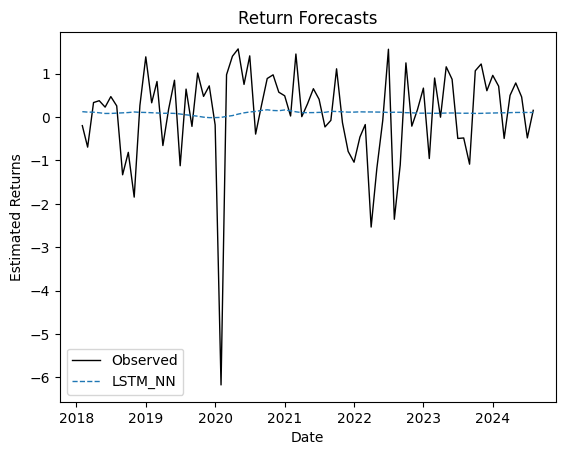

In [47]:
# Define paths for the dataset
fred_path = "https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv"
local_file_path = Path("data/current.csv")

# Load the data
df = load_data(local_file_path, fred_path)

# Preprocess the data
df = preprocess_data(df)

# Split and scale the data
train_data_scaled, test_data_scaled = split_and_scale_data(df)

# Train models
input_dim = len(train_data_scaled.columns) - 1  # Exclude the target column for input dimensions
lstm_model, lstm_history = train_lstm_model(train_data_scaled, lookback_period)

# Generate forecasts
lstm_forecasts_mean = generate_lstm_forecasts(lstm_model, test_data_scaled, lookback_period)

# Evaluate models
evaluate_models(lstm_forecasts_mean, test_data_scaled[lookback_period:])

# Plot forecasts
plot_forecasts(lstm_forecasts_mean, test_data_scaled[lookback_period:])


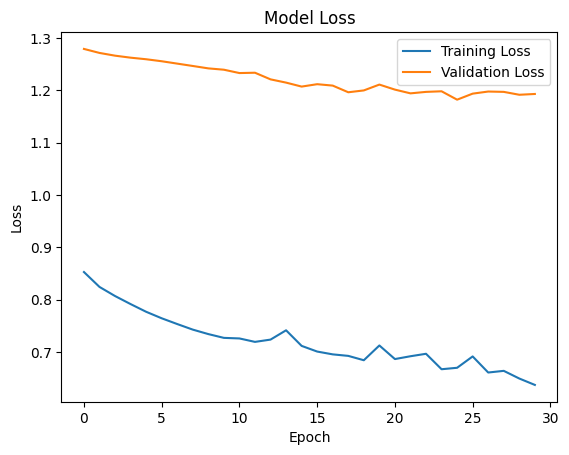

In [48]:
plt.plot(lstm_history.history['loss'], label='Training Loss')
if 'val_loss' in lstm_history.history:
    plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

###### Notes:

An LSTM model captures temporal dependencies and patterns over time, providing a built-in regularization effect. This effect becomes stonger as the lookback period is extended. In contrast, a feedforward NN may overfit by treating each input independently, ignoring temporal context.

You can see this if you increase the lookback period and disable the early stopping algorithm.